In [1]:
!pip install unidecode numpy==1.23.0 pandas==1.4.4 lightgbm==4.3.0

In [2]:
from unidecode import unidecode
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import re
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import log_evaluation

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## 1. Pipeline Ayarları

In [3]:
class CFG:
    MAIN_PATH = '../raw_data_new/'
    QUANTILE_FEATURE_RANGE = np.arange(0.1, 1.01, 0.1)

## 2. Ham Verinin Okunması, Birleştirilmesi ve Önişlenmesi

In [4]:
train_df = pd.read_csv(f'{CFG.MAIN_PATH}/train.csv')
test_df = pd.read_csv(f'{CFG.MAIN_PATH}/test.csv')
ss = pd.read_csv(f'{CFG.MAIN_PATH}/sample_submission.csv')
weather_df = pd.read_csv(f'{CFG.MAIN_PATH}/weather.csv')
holiday_df = pd.read_csv(f'{CFG.MAIN_PATH}/holidays.csv')

train_df['data'] = 'train'
test_df['data'] = 'test'
all_df = pd.concat([train_df,test_df],axis=0).reset_index(drop=True)


weather_df['ilce'] = weather_df['name'].str.lower().apply(unidecode)
weather_df = weather_df.drop(['name'],axis=1)

Zaman serisilerinde çıkarılan featureların sağlıklı olabilmesi ve sequential ilişkinin bozulmaması amacıyla ```base_df``` oluşturuldu ve her ilçe için ```bildirimsiz_sum``` değeri olmayan günler ```0``` ile dolduruldu.

In [5]:
base_date = pd.DataFrame(pd.date_range(start='2021-01-01',end='2024-02-29',freq='D'),columns=['date'])
base_df = base_date.merge(train_df[['ilce']].drop_duplicates().reset_index(drop=True),how='cross')

In [6]:
holiday_df['date'] = pd.to_datetime(holiday_df['Yıl'].astype(str) + "-" + holiday_df['Ay'].astype(str) + "-" + holiday_df['Gün'].astype(str))
holiday_df = holiday_df[['date','Tatil Adı']]

In [7]:
all_df = pd.concat([train_df,test_df],axis=0).reset_index(drop=True)
weather_df['date'] = pd.to_datetime(weather_df['date'])

all_df = all_df.rename(columns={'tarih':'date'})
all_df = all_df.sort_values(['date']).reset_index(drop=True)
all_df['date'] = pd.to_datetime(all_df['date'])

In [8]:
all_df = base_df.merge(all_df,how='left',on=['ilce','date'])
all_df['bildirimli_sum'] = all_df['bildirimli_sum'].fillna(0)
all_df['bildirimsiz_sum'] = all_df['bildirimsiz_sum'].fillna(0)
all_df.loc[all_df.data == "test", "bildirimsiz_sum"] = np.nan
all_df['data'] = all_df['data'].fillna('train')

## 3. Veri Analizi ve Görselleştirme

In [9]:
all_df_vis = all_df.merge(weather_df,how='left',on=['date','ilce'])
all_df_vis['date'] = pd.to_datetime(all_df_vis['date'])
weather_df_vis = weather_df.copy()
higher_q = all_df_vis['bildirimsiz_sum'].quantile(0.999)

### 3.1. Hava Durumu - Bildirimsiz Kesinti Sayısı İlişkisi

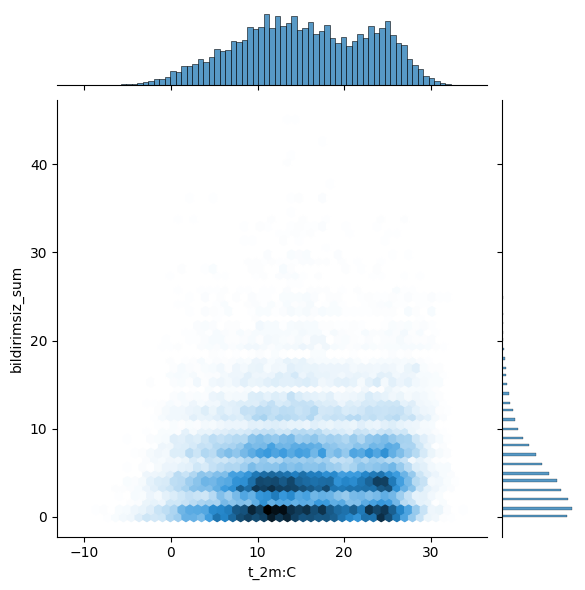

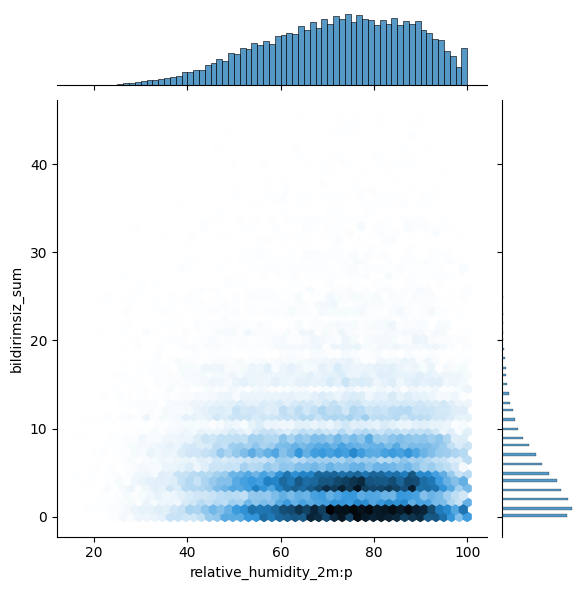

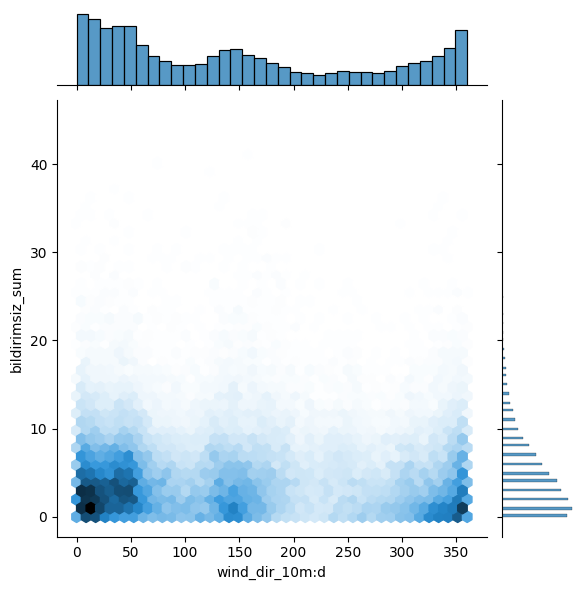

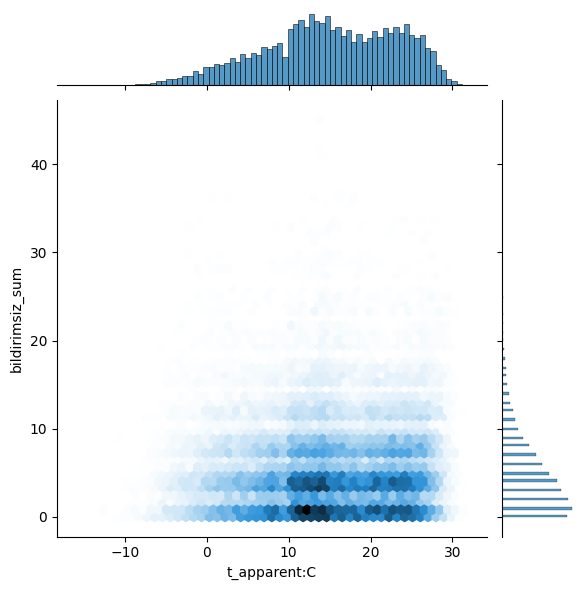

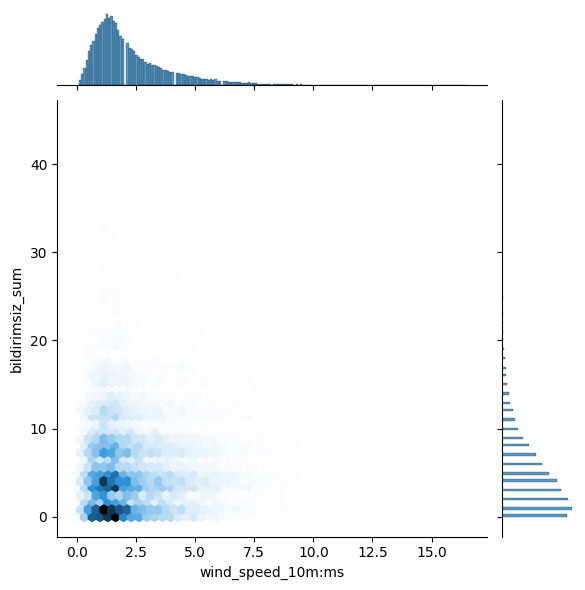

In [10]:
_ = sns.jointplot(x = "t_2m:C", y="bildirimsiz_sum", data=all_df_vis[all_df_vis['bildirimsiz_sum']<=higher_q], kind = 'hex')
_ = sns.jointplot(x = "relative_humidity_2m:p", y="bildirimsiz_sum", data=all_df_vis[all_df_vis['bildirimsiz_sum']<=higher_q], kind = 'hex')
_ = sns.jointplot(x = "wind_dir_10m:d", y="bildirimsiz_sum", data=all_df_vis[all_df_vis['bildirimsiz_sum']<=higher_q], kind = 'hex')
_ = sns.jointplot(x = "t_apparent:C", y="bildirimsiz_sum", data=all_df_vis[all_df_vis['bildirimsiz_sum']<=higher_q], kind = 'hex')
_ = sns.jointplot(x = "wind_speed_10m:ms", y="bildirimsiz_sum", data=all_df_vis[all_df_vis['bildirimsiz_sum']<=higher_q], kind = 'hex')

### 3.2. İlçe Seviyesinde Auto-Correlation

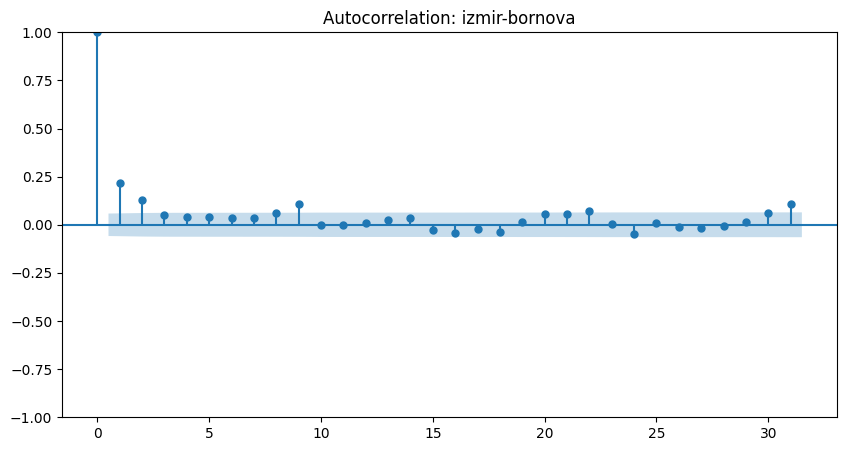

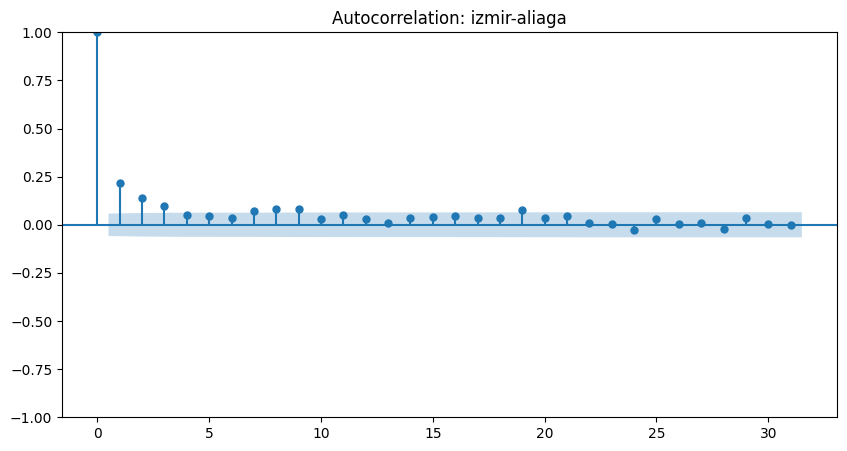

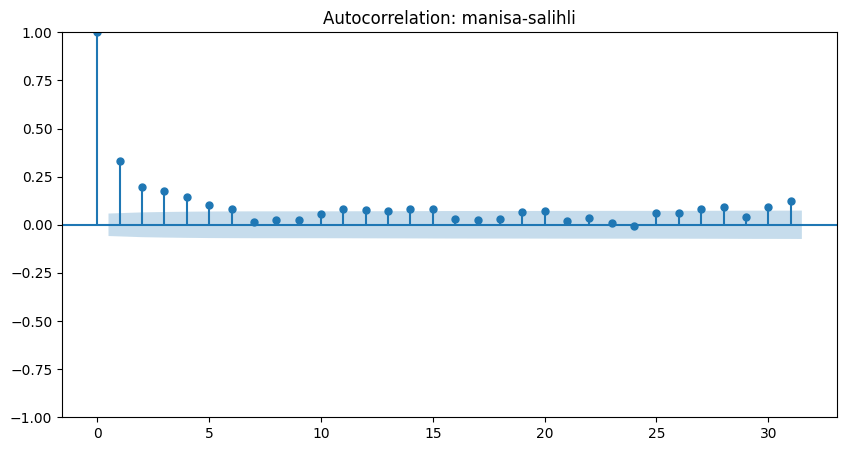

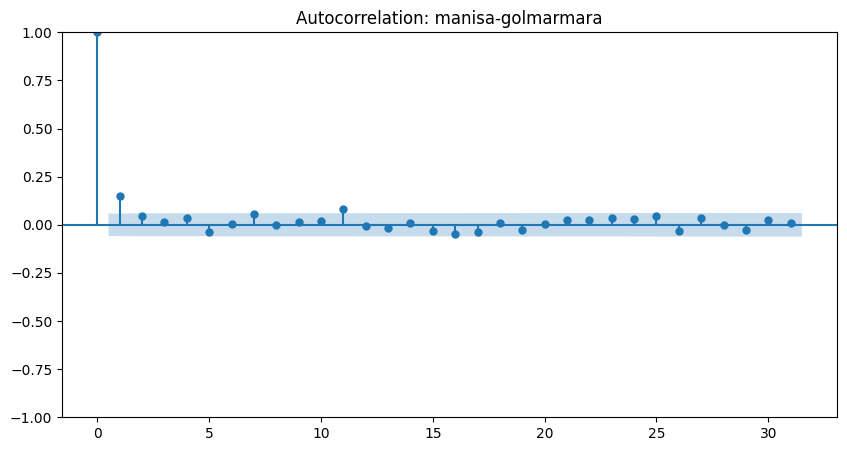

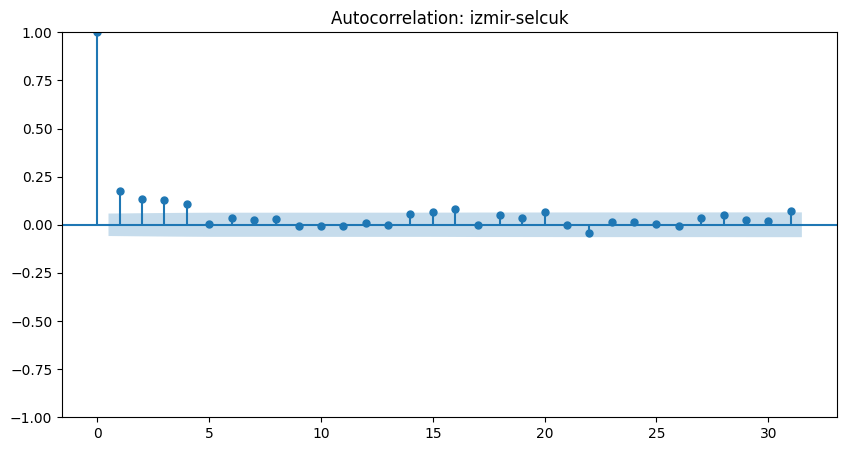

In [11]:
for ilce in ['izmir-bornova','izmir-aliaga','manisa-salihli','manisa-golmarmara','izmir-selcuk']:
    fig = plot_acf(all_df_vis[all_df_vis.ilce==ilce]['bildirimsiz_sum'].dropna().reset_index(drop=True),
                   title=f"Autocorrelation: {ilce}");
    fig.set_figwidth(10)
    fig.set_figheight(5)

### 3.3 Zamana Göre Ortalama Bildirimsiz Kesinti Sayısı

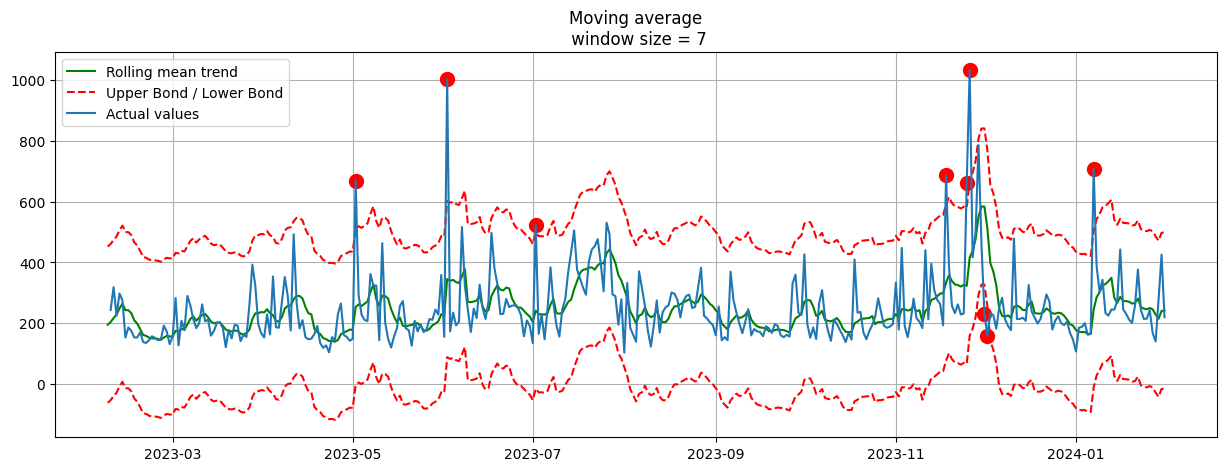

In [12]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

daily_agg_df = all_df[all_df.data=='train'].groupby(['date'])['bildirimsiz_sum'].sum().reset_index()

plotMovingAverage(daily_agg_df.set_index('date').tail(365),
                  window=7,
                  plot_intervals=True,
                  plot_anomalies=True) 

Bazı günlerde meydana gelen yüksek kesintiler (outlier varsayılabilir) dışında kesinti sayıları günlük görünümde belirli bir aralık içinde kalıyor gibi duruyor.

### 3.4. Zaman ve İlçeye Göre Ortalama Bildirimsiz Kesinti Sayısı

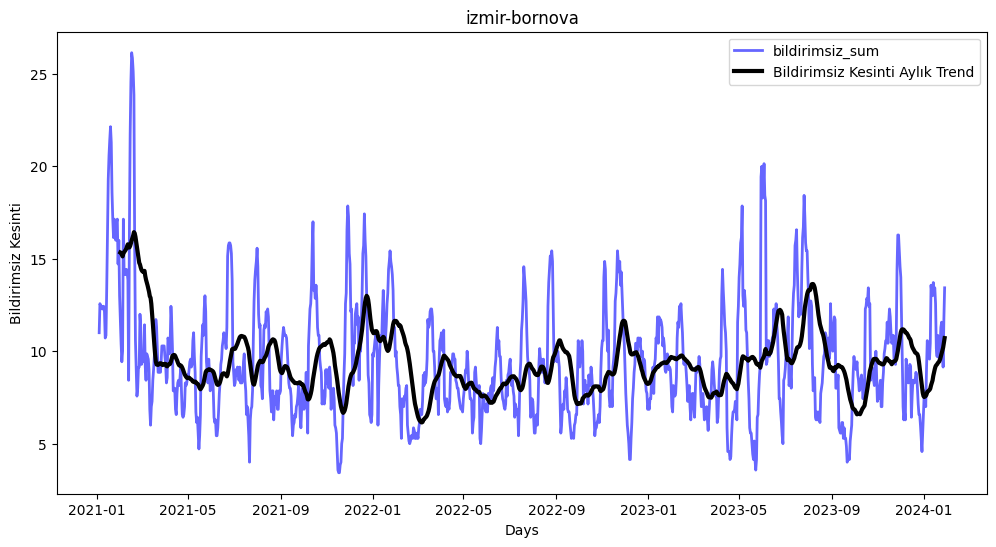

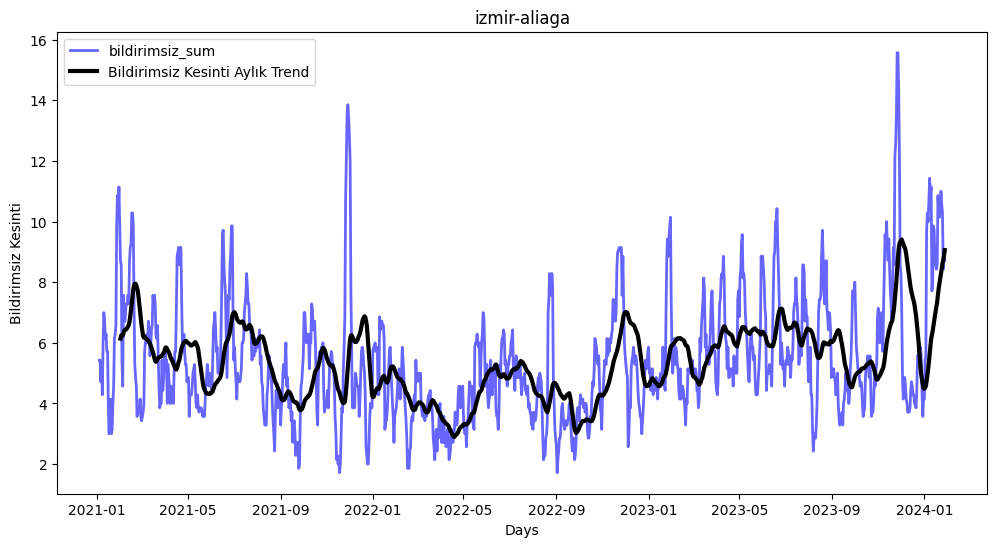

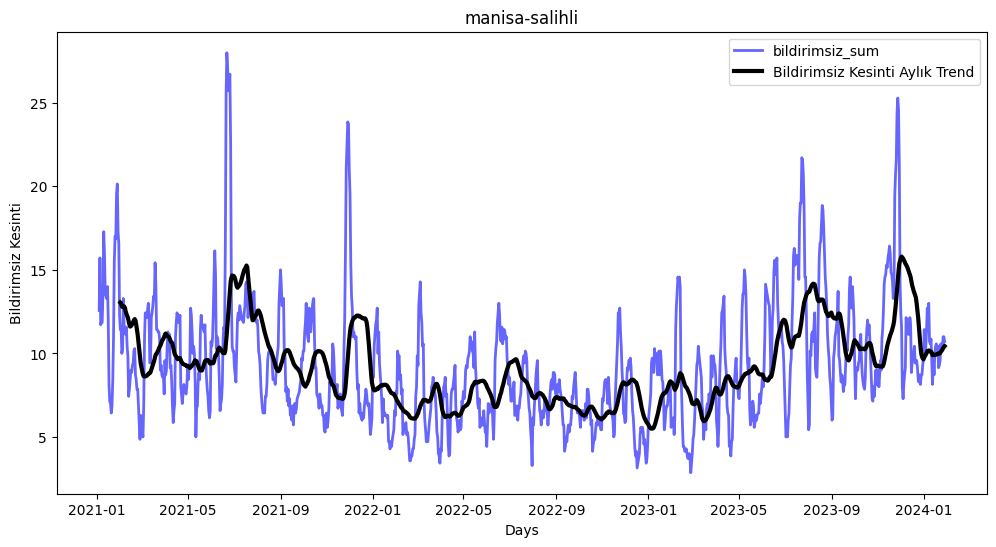

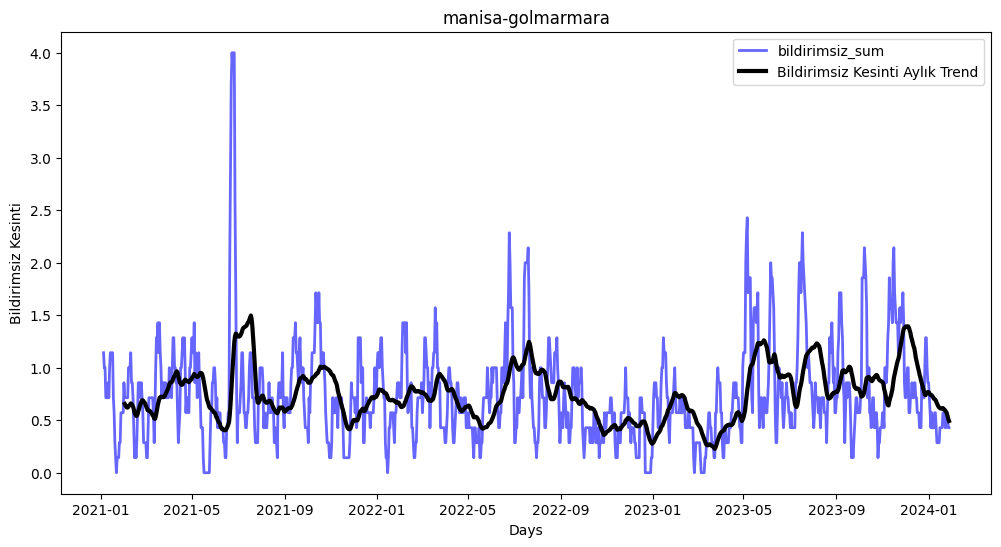

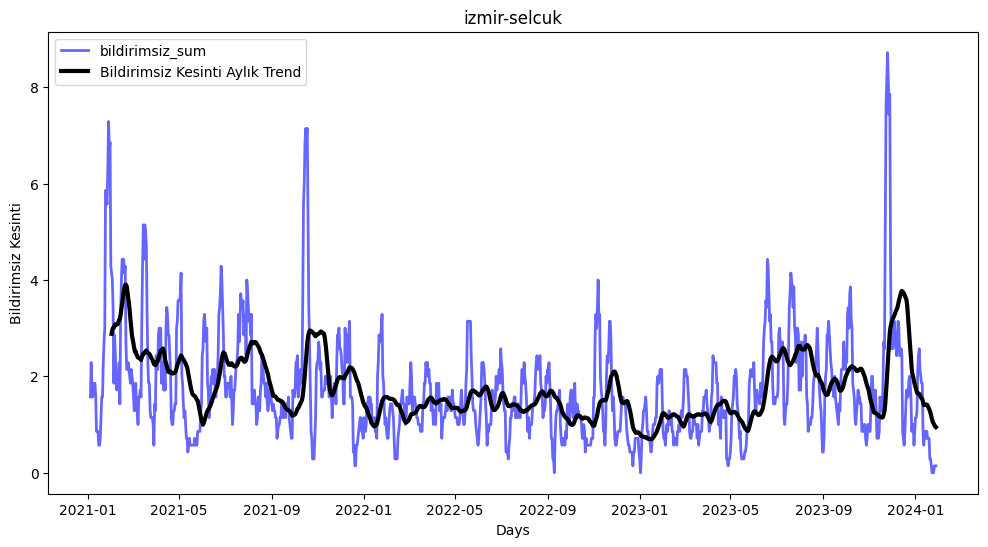

In [13]:
for ilce in ['izmir-bornova','izmir-aliaga','manisa-salihli','manisa-golmarmara','izmir-selcuk']:
    decomposed_results = seasonal_decompose(all_df_vis[all_df_vis.ilce==ilce][['date','bildirimsiz_sum']].set_index('date').dropna(), period=7)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(decomposed_results.trend, alpha=0.6, color='blue', label='bildirimsiz_sum', linewidth = 2.0)
    ax.plot(decomposed_results.trend.rolling(29).mean(), alpha=1, color='black', label='Bildirimsiz Kesinti Aylık Trend', linewidth = 3.0)
    
    ax.legend(loc='best')
    ax.set_title(ilce)
    ax.set_ylabel("Bildirimsiz Kesinti")
    ax.set_xlabel("Days")
    plt.show()

### 3.5. Değişkenler Arasındaki Korelasyon

Korelasyon katsayılarına baktığımızda bildirimsiz kesintiler ile doğrusal bir ilişki bulamıyoruz. Rüzgar hızı diğer hava durumu göstergelerine göre daha pozitif ayrışmaktadır. Yüksek rüzgar hızı değerlerinde bildirimsiz kesintilerin artması muhtemel gibi duruyor.

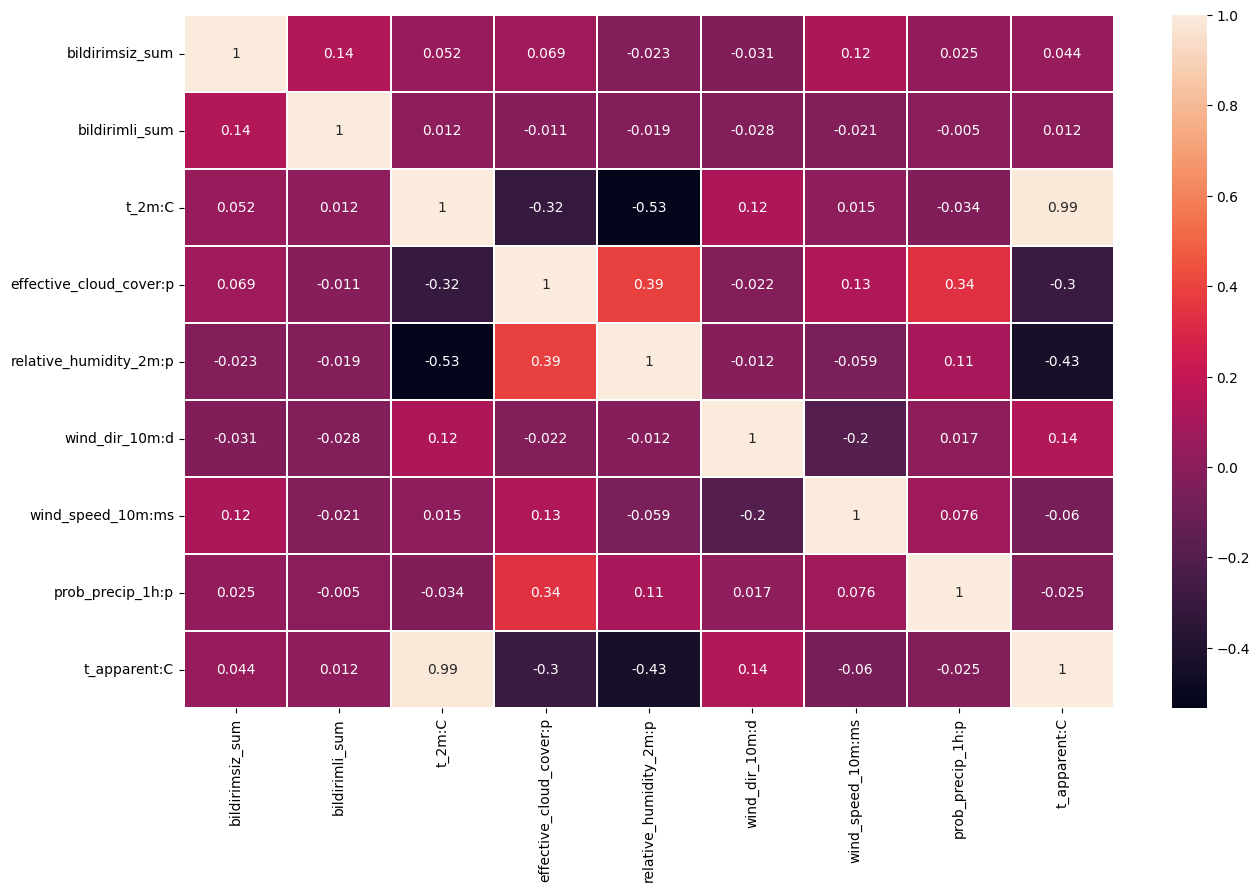

In [14]:
corr = all_df_vis.select_dtypes(include=['float','int']).drop(['global_rad:W','lat','lon'],axis=1).corr()
plt.figure(figsize=(15,9))
ax = sns.heatmap(corr, annot=True,linewidths=.1)
plt.yticks(rotation=0)
plt.show()

## 4. Feature Engineering

Hava durumu, tatil ve kesintilerin geçmiş değerlerini kullanarak featurelar ürettik. En genel anlamıyla çıkarılan featurelar şöyle sıralanabilir:
1. Hava durumu istatistikleri
    * Gün-ilçe kırılımında minumum, ortalama, maksimum ve quantile değerler
    * Gün kırılımında minumum, ortalama, maksimum ve quantile değerler
    * Gün ilçe ve saat kırılımındaki değerlerin aggregation olmadan columnwise verilmesi
2. Target rolling, expanding ve shift featureları
3. Datetime featureları
4. Tatil günlerine kaç gün kaldığını simgeleyen featurelar

### 4.1 Günlük Quantile Hava Durumu Featureları

In [15]:
# Gün-ilçe kırılımında quantile değerler

for q in CFG.QUANTILE_FEATURE_RANGE:
    q_weather_df = weather_df.drop(columns=["lat","lon"]).groupby(['date','ilce']).quantile(q)
    q_weather_df.columns = [f"{col}_q{q}" for col in q_weather_df.columns]
    all_df = all_df.merge(q_weather_df.reset_index(),how='left',on=['ilce','date'])
    del q_weather_df

In [16]:
weather_df['date'] = weather_df['date'].dt.date

In [17]:
# Gün kırılımında quantile değerler

for q in CFG.QUANTILE_FEATURE_RANGE:
    q_weather_df = weather_df.drop(columns=["lat", "lon", "ilce"]).groupby(['date']).quantile(q)
    q_weather_df.columns = [f"{col}_date_allstates_q{q}" for col in q_weather_df.columns]
    q_weather_df.reset_index(inplace=True)
    q_weather_df["date"] = pd.to_datetime(q_weather_df["date"])
    all_df = all_df.merge(q_weather_df,how='left',on=['date'])
    del q_weather_df

### 4.2 Günlük Aggregated Hava Durumu Featureları

In [18]:
def weather_agg_features_fn(df_temp,
                         groups,
                         feature_dict,
                         prefix='_'):
    df_agg = df_temp.groupby(groups).agg(feature_dict)
    df_agg.columns = [f"{prefix}".join(col) for col in df_agg]
    df_agg = df_agg.reset_index() 
    return df_agg

In [19]:
# Hava durumu featureları için ayarlar

daily_state_agg_feature_dict = {
        'lat': ['mean'],
        'lon': ['mean'],
        't_2m:C': ['mean','max'],
        'effective_cloud_cover:p': ['mean','max'],
        'global_rad:W': ['mean','max'],
        'relative_humidity_2m:p': ['mean','max'],
        'wind_dir_10m:d': ['mean','max'],
        'wind_speed_10m:ms': ['mean','max'],
        'prob_precip_1h:p': ['mean','max'],
        't_apparent:C': ['mean','max'],
    
    }
daily_agg_feature_dict = {
        't_2m:C': ['mean','max'],
        'effective_cloud_cover:p': ['mean','max'],
        'global_rad:W': ['mean','max'],
        'relative_humidity_2m:p': ['mean','max'],
        'wind_dir_10m:d': ['mean','max'],
        'wind_speed_10m:ms': ['mean','max'],
        'prob_precip_1h:p': ['mean','max'],
        't_apparent:C': ['mean','max'],
    
    }

In [20]:
weather_df_gb = weather_agg_features_fn(df_temp=weather_df,
                                        groups=['date','ilce'],
                                        feature_dict=daily_state_agg_feature_dict)
weather_df_gb['date'] = pd.to_datetime(weather_df_gb['date'])

In [21]:
weather_df_gb_date = weather_agg_features_fn(df_temp=weather_df,
                                             groups=['date'],
                                             feature_dict=daily_agg_feature_dict,
                                             prefix='_date_')
weather_df_gb_date['date'] = pd.to_datetime(weather_df_gb_date['date'])

### 4.3 Saatlik Column-wise Hava Durumu Featureları

In [22]:
hourly_state_agg_feature_dict = {
    't_2m:C': ['mean'],
    'effective_cloud_cover:p': ['mean'],
    'global_rad:W': ['mean'],
    'relative_humidity_2m:p': ['mean'],
    'wind_dir_10m:d': ['mean'],
    'wind_speed_10m:ms': ['mean'],
    'prob_precip_1h:p': ['mean'],
    't_apparent:C': ['mean'],

}

In [23]:
weather_df_pivot = pd.read_csv(f'{CFG.MAIN_PATH}/weather.csv')
weather_df_pivot['ilce'] = weather_df_pivot['name'].str.lower().apply(unidecode)
weather_df_pivot = weather_df_pivot.drop(['name'],axis=1)
weather_df_pivot['date'] = pd.to_datetime(weather_df_pivot['date'])
weather_df_pivot["hour"] = weather_df_pivot['date'].dt.hour.astype(str)
weather_df_pivot['date'] = weather_df_pivot['date'].dt.date

In [24]:
weather_df_pivot = weather_agg_features_fn(df_temp=weather_df_pivot,
                                     groups=['date','ilce','hour'],
                                     feature_dict=hourly_state_agg_feature_dict,
                                     prefix='_hour_')
weather_df_pivot_columns = weather_df_pivot.columns
weather_df_pivot = weather_df_pivot.pivot_table(values=weather_df_pivot.drop(columns=['date','ilce','hour'],axis=1).columns,
                                                index=['date','ilce'],
                                                columns='hour',
                                                fill_value=np.nan)
weather_df_pivot.columns = ["_".join(col) for col in weather_df_pivot.columns]
weather_df_pivot = weather_df_pivot.reset_index()
weather_df_pivot['date'] = pd.to_datetime(weather_df_pivot['date'])

Bütün hava durumu featurelarının mergelenmesi

In [25]:
all_df = all_df.merge(weather_df_gb,how='left',on=['ilce','date'])
all_df = all_df.merge(weather_df_gb_date,how='left',on=['date'])
all_df = all_df.merge(weather_df_pivot,how='left',on=['ilce','date'])

### 4.4 Label Üzerinde Lag, Rolling ve Expanding Featurelar

In [26]:
def shift_and_rolling_mean(group):
    for feature in ['bildirimsiz_sum']:
        for shift in [29]:
            group[f'{feature}_shift_{shift}'] = group[feature].shift(shift)
            group[f'{feature}_shift_{shift}_expanding_mean'] = group[feature].shift(shift).expanding().mean()
            group[f'{feature}_shift_{shift}_expanding_median'] = group[feature].shift(shift).expanding().median()
            group[f'{feature}_shift_{shift}_expanding_sum'] = group[feature].shift(shift).expanding().sum()
            group[f'{feature}_shift_{shift}_expanding_max'] = group[feature].shift(shift).expanding().max()
            group[f'{feature}_shift_{shift}_expanding_skew'] = group[feature].shift(shift).expanding().skew()
            group[f'{feature}_shift_{shift}_expanding_std'] = group[feature].shift(shift).expanding().std()
            group[f'{feature}_shift_{shift}_expanding_kurt'] = group[feature].shift(shift).expanding().kurt()
            group[f'{feature}_shift_{shift}_expanding_var'] = group[feature].shift(shift).expanding().var()
            group[f'{feature}_shift_{shift}_expanding_days_since_max'] =\
                    group[feature].shift(shift).expanding().apply(lambda x: 1.0 - np.argmax(x[::-1]) if len(x) > 0 else np.NaN)
            
            for rolling in [3,7,14,29,29*2]:
                group[f'{feature}_shift_{shift}_rolling_{rolling}_sum'] = group[feature].shift(shift).rolling(window=rolling,min_periods=rolling).sum()
                group[f'{feature}_shift_{shift}_rolling_{rolling}_median'] = group[feature].shift(shift).rolling(window=rolling,min_periods=rolling).median()
                group[f'{feature}_shift_{shift}_rolling_{rolling}_mean'] = group[feature].shift(shift).rolling(window=rolling,min_periods=rolling).mean()
                group[f'{feature}_shift_{shift}_rolling_{rolling}_max'] = group[feature].shift(shift).rolling(window=rolling,min_periods=rolling).max()
                group[f'{feature}_shift_{shift}_rolling_{rolling}_min'] = group[feature].shift(shift).rolling(window=rolling,min_periods=rolling).min()
                group[f'{feature}_shift_{shift}_rolling_{rolling}_std'] = group[feature].shift(shift).rolling(window=rolling,min_periods=rolling).std()
                group[f'{feature}_shift_{shift}_rolling_{rolling}_skew'] = group[feature].shift(shift).rolling(window=rolling,min_periods=rolling).skew()
                group[f'{feature}_shift_{shift}_rolling_{rolling}_kurt'] = group[feature].shift(shift).rolling(window=rolling,min_periods=rolling).kurt()
                group[f'{feature}_shift_{shift}_rolling_{rolling}_var'] = group[feature].shift(shift).rolling(window=rolling,min_periods=rolling).var()

    return group

all_df = all_df.groupby(all_df['ilce'],group_keys=False).apply(shift_and_rolling_mean)

### 4.5 Datetime Featurelar

In [27]:
def datetime_feature_fn(df_temp):
    """
    Datetime feature üretir.
    """
    df_temp['month'] = df_temp['date'].dt.month
    df_temp['dayofweek'] = df_temp['date'].dt.dayofweek
    df_temp['quarter'] = df_temp['date'].dt.quarter
    df_temp['weekofyear'] = df_temp['date'].dt.isocalendar().week

    return df_temp
all_df = datetime_feature_fn(all_df)

### 4.6 Tatil Featureları

In [28]:
all_df = all_df.merge(holiday_df,how='left',on='date')
all_df['Tatil Adı'] = all_df['Tatil Adı'].fillna('No Holiday')

In [29]:
holiday_features_df = pd.get_dummies(all_df[['date',"Tatil Adı"]],columns=["Tatil Adı"])
holiday_features_df = holiday_features_df.drop_duplicates()

is_next_days_cols = ['Commemoration of Ataturk, Youth and Sports Day',
 'Republic Day',
 'Democracy and National Unity Day',
 'Labour Day',
 'Sacrifice Feast Holiday* (*estimated)',
 'Ramadan Feast Holiday* (*estimated)',
 "National Sovereignty and Children's Day",
 "National Sovereignty and Children's Day; Ramadan Feast Holiday* (*estimated)",
 "New Year's Day",
 'Victory Day']

for i in [3,7,15]:
    for col in is_next_days_cols:
        holiday_features_df[f"is_{col}_in_next_{i}_days"] = holiday_features_df[f"Tatil Adı_{col}"].rolling(i).sum().shift(-i)
all_df = all_df.merge(holiday_features_df[["date"] + [col for col in holiday_features_df.columns if "_in_next_" in col]].fillna(0),how='left',on='date')

In [30]:
all_df["il"] = all_df["ilce"].str.split("-").str[0]
all_df["ilce"] = all_df["ilce"].str.split("-").str[1]

In [31]:
all_df = all_df.sort_values(by=["ilce", "date"], ascending=True).reset_index(drop=True)

In [32]:
for month_id, (ts_obj, group_df) in enumerate(list(all_df.groupby(pd.Grouper(key='date', freq='M')))):
    all_df.loc[group_df.index, "month_id"] = month_id

### 4.7 İlçe Bazında Geçen Aya Ait Etiket Değeri İstatistikleri

In [33]:
all_df = all_df.merge(all_df.groupby(['ilce','month_id'],group_keys=False,sort=False)['bildirimsiz_sum'].mean().shift(1).reset_index().rename(columns={'bildirimsiz_sum':'bildirimsiz_sum_last_1_month_mean'}),
            how='left',on=['ilce','month_id'])
all_df['bildirimsiz_sum_last_1_month_mean'] = all_df['bildirimsiz_sum_last_1_month_mean'].fillna(0)

all_df = all_df.merge(all_df.groupby(['ilce','month_id'],group_keys=False,sort=False)['bildirimsiz_sum'].sum().shift(1).reset_index().rename(columns={'bildirimsiz_sum':'bildirimsiz_sum_last_1_month_sum'}),
            how='left',on=['ilce','month_id'])
all_df['bildirimsiz_sum_last_1_month_sum'] = all_df['bildirimsiz_sum_last_1_month_sum'].fillna(0)

all_df = all_df.merge(all_df.groupby(['ilce','month_id'],group_keys=False,sort=False)['bildirimsiz_sum'].std().shift(1).reset_index().rename(columns={'bildirimsiz_sum':'bildirimsiz_sum_last_1_month_std'}),
            how='left',on=['ilce','month_id'])
all_df['bildirimsiz_sum_last_1_month_std'] = all_df['bildirimsiz_sum_last_1_month_std']

all_df = all_df.merge(all_df.groupby(['ilce','month_id'],group_keys=False,sort=False)['bildirimsiz_sum'].median().shift(1).reset_index().rename(columns={'bildirimsiz_sum':'bildirimsiz_sum_last_1_month_median'}),
            how='left',on=['ilce','month_id'])
all_df['bildirimsiz_sum_last_1_month_median'] = all_df['bildirimsiz_sum_last_1_month_median']

all_df = all_df.merge(all_df.groupby(['ilce','month_id'],group_keys=False,sort=False)['bildirimsiz_sum'].max().shift(1).reset_index().rename(columns={'bildirimsiz_sum':'bildirimsiz_sum_last_1_month_max'}),
            how='left',on=['ilce','month_id'])
all_df['bildirimsiz_sum_last_1_month_max'] = all_df['bildirimsiz_sum_last_1_month_max']

### 4.8 Veri Genlide Geçen Aya Ait Etiket Değeri İstatistikleri

In [34]:
for i in [29]:
    all_df = all_df.merge(all_df.groupby(['date'],sort=False)['bildirimsiz_sum'].sum().shift(i).reset_index().rename(columns={'bildirimsiz_sum':f'bildirimsiz_sum_shift_{i}_by_date'}),
            how='left',on=['date'])

all_df = all_df.merge(all_df.groupby(['date'],sort=False)['bildirimsiz_sum'].skew().shift(29).reset_index().rename(columns={'bildirimsiz_sum':'bildirimsiz_sum_last_month_same_day_skew'}),
            how='left',on=['date'])

all_df = all_df.merge(all_df.groupby(['date'],sort=False)['bildirimsiz_sum'].max().shift(29).reset_index().rename(columns={'bildirimsiz_sum':'bildirimsiz_sum_last_month_same_day_max'}),
            how='left',on=['date'])
all_df = all_df.merge(all_df.groupby(['date'],sort=False)['bildirimsiz_sum'].std().shift(29).reset_index().rename(columns={'bildirimsiz_sum':'bildirimsiz_sum_last_month_same_day_std'}),
            how='left',on=['date'])
all_df = all_df.merge(all_df.groupby(['date'],sort=False)['bildirimsiz_sum'].mean().shift(29).reset_index().rename(columns={'bildirimsiz_sum':'bildirimsiz_sum_last_month_same_day_mean'}),
            how='left',on=['date'])

### 4.9 İlçe Bazında Kesintisiz ve Kesintili Gün Sayısı

In [35]:
all_df['bildirimsiz_sum_not_zero'] = (all_df['bildirimsiz_sum']>0).astype(int)
all_df['bildirimsiz_sum_zero'] = (all_df['bildirimsiz_sum']==0).astype(int)

all_df = all_df.merge(all_df.groupby(['ilce','month_id'],group_keys=False,sort=False)[['bildirimsiz_sum_not_zero','bildirimsiz_sum_zero']].sum().shift(1).reset_index().rename(columns={
    'bildirimsiz_sum_not_zero':'bildirimsiz_sum_last_month_non_zero_sum',
    'bildirimsiz_sum_zero':'bildirimsiz_sum_last_month_zero_sum'}), how='left', on=['ilce','month_id'])

all_df = all_df.drop(['bildirimsiz_sum_not_zero','bildirimsiz_sum_zero'], axis=1)
all_df[['bildirimsiz_sum_last_month_non_zero_sum','bildirimsiz_sum_last_month_zero_sum']] = all_df[['bildirimsiz_sum_last_month_non_zero_sum','bildirimsiz_sum_last_month_zero_sum']].fillna(-1)

## 5. Eğitim ve Doğrulama

In [36]:
cat_features = ['ilce', 'Tatil Adı']
exclude_cols = ['date', 'data', 'month_id', 'il']
target = 'bildirimsiz_sum'

for col in cat_features:
    all_df[col] = all_df[col].astype('category')

In [37]:
train_df = all_df[all_df.data=='train'].dropna(subset=[target])
train_df = train_df.sort_values(['date']).reset_index(drop=True)

sub_df = all_df[all_df.data=='test']

Verideki son 7 ayı time-series split stratejisi ile doğrulama için kullandık. Yarışmanın ilk etabında 6'dı fakat veri son etapta bir ay daha uzayınca 7'ye çıkardık.

In [38]:
val_months = sorted(train_df["month_id"].unique())[-7:]
cv_splits = [
    (list(train_df[train_df["month_id"]<val_month].index), list(train_df[train_df["month_id"]==val_month].index))
    for val_month in val_months
]

In [39]:
sub_df = sub_df.drop(exclude_cols + [target],axis=1)
y = train_df[target]
X = train_df.drop(exclude_cols + [target],axis=1)

### 5.1. Feature Selection
CatBoost kullanarak **SHAP** değerlerine göre bütün foldlarda iyi performans gösteren featureları seçtik.

In [40]:
selfeats = ['bildirimsiz_sum_last_1_month_max',
            't_apparent:C_hour_mean_9',
            'bildirimsiz_sum_shift_29_rolling_29_sum',
            'bildirimsiz_sum_shift_29_rolling_7_median',
            'wind_speed_10m:ms_date_allstates_q0.8',
            'prob_precip_1h:p_hour_mean_4',
            'bildirimsiz_sum_shift_29_rolling_58_var',
            'wind_dir_10m:d_hour_mean_14',
            'bildirimsiz_sum_shift_29_rolling_3_max',
            'prob_precip_1h:p_max',
            'wind_speed_10m:ms_max',
            'effective_cloud_cover:p_hour_mean_3',
            'bildirimsiz_sum_shift_29_rolling_58_median',
            'global_rad:W_hour_mean_6',
            'relative_humidity_2m:p_hour_mean_16',
            'bildirimsiz_sum_shift_29_rolling_58_kurt',
            'Tatil Adı',
            'global_rad:W_hour_mean_19',
            'bildirimsiz_sum_last_1_month_mean',
            't_apparent:C_hour_mean_10',
            't_apparent:C_date_allstates_q0.1',
            'bildirimsiz_sum_shift_29_rolling_58_std',
            'bildirimsiz_sum_shift_29_rolling_14_min',
            'wind_dir_10m:d_date_allstates_q0.30000000000000004',
            'global_rad:W_hour_mean_18',
            'bildirimsiz_sum_shift_29_expanding_mean',
            'prob_precip_1h:p_hour_mean_16',
            'prob_precip_1h:p_date_allstates_q0.7000000000000001',
            'month',
            'wind_dir_10m:d_date_mean',
            'bildirimsiz_sum_last_month_zero_sum',
            'wind_dir_10m:d_hour_mean_15',
            'bildirimsiz_sum_shift_29_rolling_29_median',
            "is_New Year's Day_in_next_15_days",
            't_apparent:C_date_allstates_q0.6',
            'ilce',
            'prob_precip_1h:p_hour_mean_19',
            'bildirimsiz_sum_shift_29_rolling_3_median',
            'bildirimsiz_sum_shift_29',
            'quarter',
            'bildirimsiz_sum_shift_29_expanding_median',
            'relative_humidity_2m:p_date_mean',
            'bildirimsiz_sum_shift_29_rolling_14_sum',
            'bildirimsiz_sum_shift_29_rolling_7_sum',
            'bildirimsiz_sum_shift_29_rolling_29_skew',
            'global_rad:W_date_allstates_q0.4',
            'global_rad:W_hour_mean_15',
            't_2m:C_date_allstates_q0.5',
            'lon_mean',
            'bildirimsiz_sum_shift_29_rolling_58_sum',
            't_apparent:C_hour_mean_4',
            'bildirimsiz_sum_last_month_same_day_skew',
            'wind_speed_10m:ms_date_allstates_q0.4',
            'wind_dir_10m:d_date_allstates_q0.2',
            'global_rad:W_date_allstates_q0.5',
            'bildirimsiz_sum_shift_29_rolling_29_kurt',
            'bildirimsiz_sum_shift_29_expanding_max',
            'global_rad:W_date_allstates_q0.8',
            'wind_speed_10m:ms_hour_mean_23',
            'effective_cloud_cover:p_date_allstates_q0.2',
            'bildirimsiz_sum_last_1_month_std',
            'bildirimsiz_sum_last_month_same_day_max',
            'bildirimsiz_sum_shift_29_rolling_3_sum',
            'lat_mean',
            'is_Democracy and National Unity Day_in_next_15_days',
            't_apparent:C_hour_mean_20',
            'bildirimsiz_sum_shift_29_rolling_3_min',
            'global_rad:W_hour_mean_20',
            't_2m:C_hour_mean_4',
            'global_rad:W_hour_mean_9',
            't_2m:C_hour_mean_19',
            'bildirimsiz_sum_shift_29_rolling_29_std',
            'dayofweek',
            'prob_precip_1h:p_date_allstates_q1.0',
            'bildirimsiz_sum_shift_29_rolling_58_max',
            't_apparent:C_hour_mean_8',
            'bildirimsiz_sum_shift_29_rolling_3_std',
            'effective_cloud_cover:p_hour_mean_23',
            'wind_speed_10m:ms_date_allstates_q0.30000000000000004',
            'bildirimsiz_sum_shift_29_expanding_kurt',
            'global_rad:W_date_allstates_q0.9',
            'wind_dir_10m:d_hour_mean_1',
            'bildirimsiz_sum_shift_29_expanding_sum',
            'effective_cloud_cover:p_date_allstates_q0.8',
            'effective_cloud_cover:p_hour_mean_12',
            'bildirimsiz_sum_shift_29_rolling_14_median',
            'bildirimsiz_sum_last_1_month_median',
            'wind_speed_10m:ms_date_allstates_q1.0',
            'prob_precip_1h:p_date_allstates_q0.9',
            'prob_precip_1h:p_date_allstates_q0.8',
            'bildirimsiz_sum_last_1_month_sum',
            'global_rad:W_date_allstates_q0.6',
            'effective_cloud_cover:p_date_allstates_q0.9',
            'wind_dir_10m:d_date_allstates_q0.1',
            'wind_dir_10m:d_hour_mean_11',
            'wind_speed_10m:ms_hour_mean_7',
            'bildirimsiz_sum_shift_29_rolling_58_min'
           ]
selfeats = sorted(selfeats)
    
print(f'{len(selfeats)} feature seçildi.')

97 feature seçildi.


### 5.2. Cross-Validation

Training data shape: (42817, 97), Validation data shape: (1457, 97)
[100]	training's l1: 2.44818	valid_1's l1: 3.48323
[200]	training's l1: 2.3596	valid_1's l1: 3.44531
[300]	training's l1: 2.29028	valid_1's l1: 3.44184
[400]	training's l1: 2.23057	valid_1's l1: 3.39596
[500]	training's l1: 2.1824	valid_1's l1: 3.34379
Score FOLD-1:3.3266986959505833


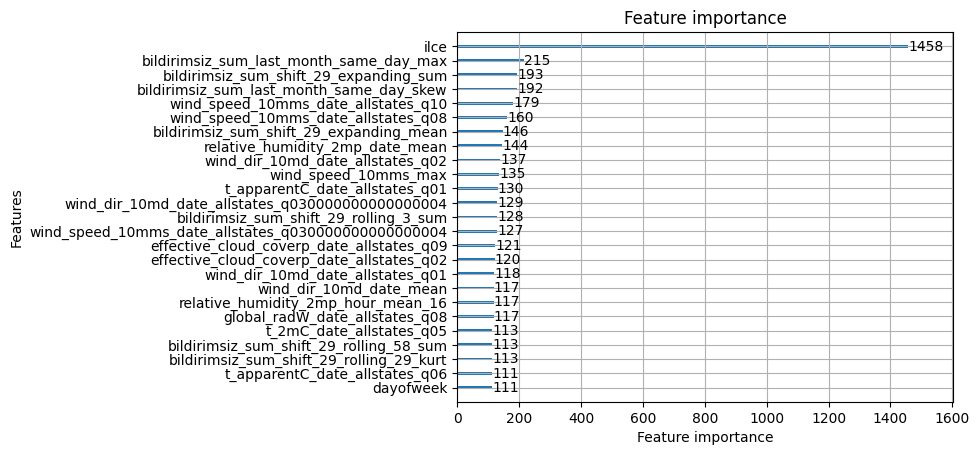

**************************************************
Training data shape: (44274, 97), Validation data shape: (1457, 97)
[100]	training's l1: 2.47511	valid_1's l1: 2.63569
[200]	training's l1: 2.38056	valid_1's l1: 2.64519
[300]	training's l1: 2.3136	valid_1's l1: 2.63288
[400]	training's l1: 2.26043	valid_1's l1: 2.62922
[500]	training's l1: 2.21477	valid_1's l1: 2.62658
Score FOLD-2:2.617021276595745


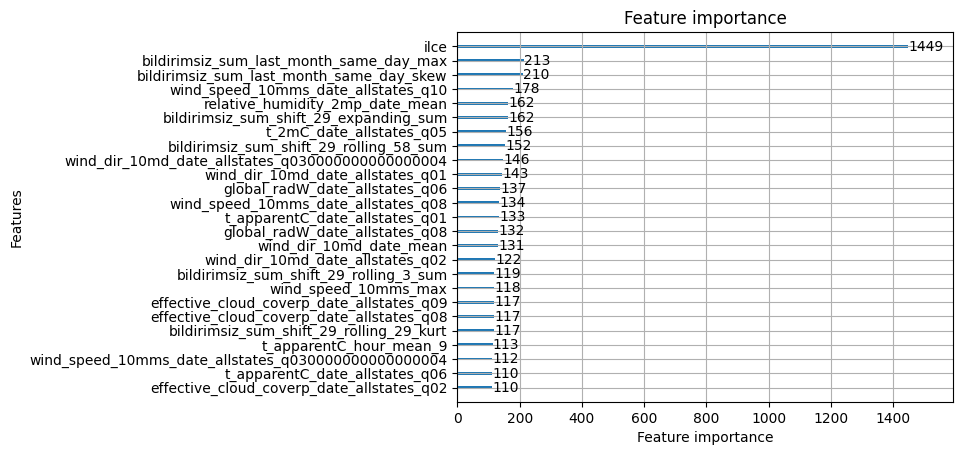

**************************************************
Training data shape: (45731, 97), Validation data shape: (1410, 97)
[100]	training's l1: 2.47647	valid_1's l1: 2.18104
[200]	training's l1: 2.39106	valid_1's l1: 2.18656
[300]	training's l1: 2.321	valid_1's l1: 2.18843
[400]	training's l1: 2.26539	valid_1's l1: 2.18673
[500]	training's l1: 2.21699	valid_1's l1: 2.17575
Score FOLD-3:2.1595744680851063


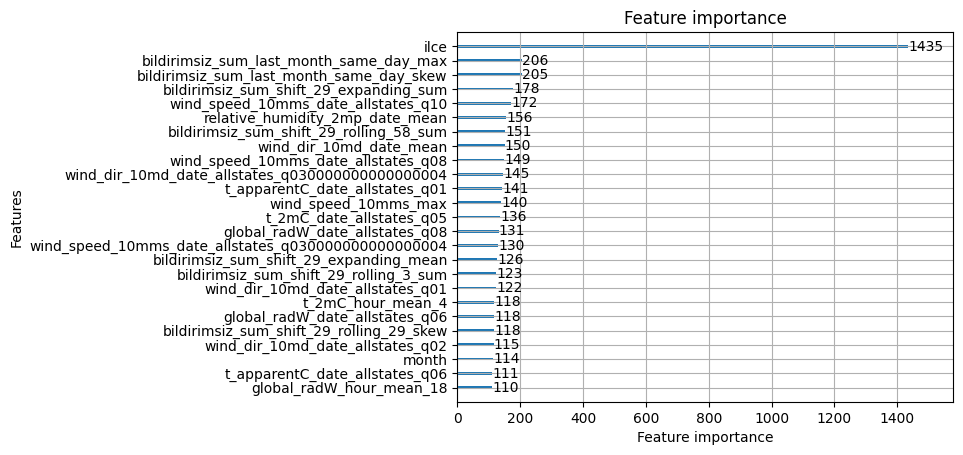

**************************************************
Training data shape: (47141, 97), Validation data shape: (1457, 97)
[100]	training's l1: 2.46529	valid_1's l1: 2.26732
[200]	training's l1: 2.37421	valid_1's l1: 2.27175
[300]	training's l1: 2.30502	valid_1's l1: 2.274
[400]	training's l1: 2.25178	valid_1's l1: 2.27206
[500]	training's l1: 2.21324	valid_1's l1: 2.26689
Score FOLD-4:2.250514756348662


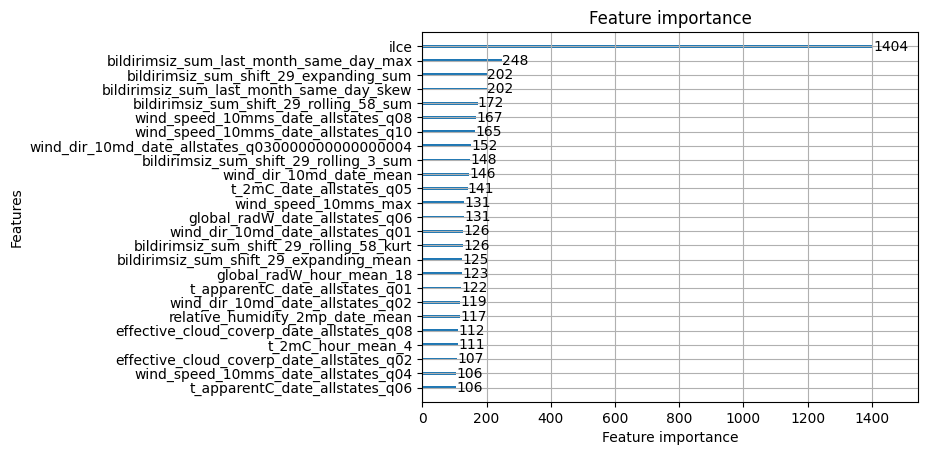

**************************************************
Training data shape: (48598, 97), Validation data shape: (1410, 97)
[100]	training's l1: 2.45913	valid_1's l1: 4.05625
[200]	training's l1: 2.37299	valid_1's l1: 3.96649
[300]	training's l1: 2.30445	valid_1's l1: 3.89072
[400]	training's l1: 2.25752	valid_1's l1: 3.86841
[500]	training's l1: 2.21123	valid_1's l1: 3.88611
Score FOLD-5:3.8659574468085105


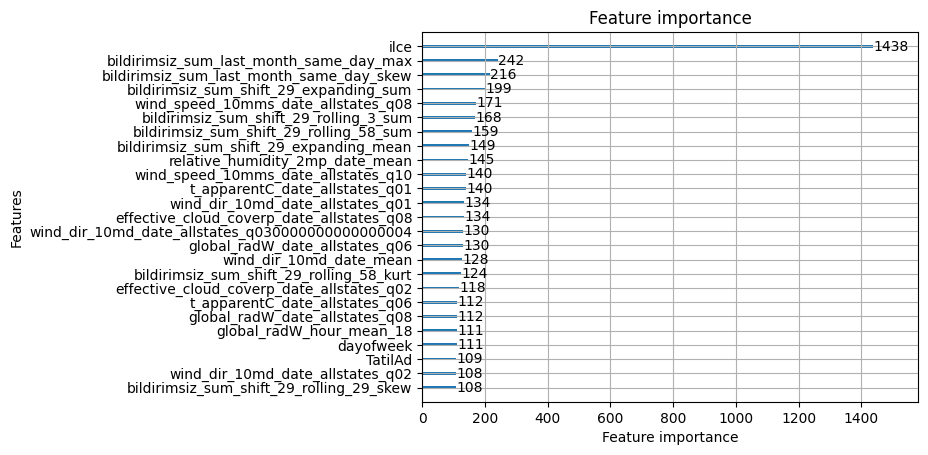

**************************************************
Training data shape: (50008, 97), Validation data shape: (1457, 97)
[100]	training's l1: 2.49732	valid_1's l1: 2.31984
[200]	training's l1: 2.40112	valid_1's l1: 2.32542
[300]	training's l1: 2.33264	valid_1's l1: 2.33117
[400]	training's l1: 2.28078	valid_1's l1: 2.33443
[500]	training's l1: 2.23951	valid_1's l1: 2.34446
Score FOLD-6:2.34248455730954


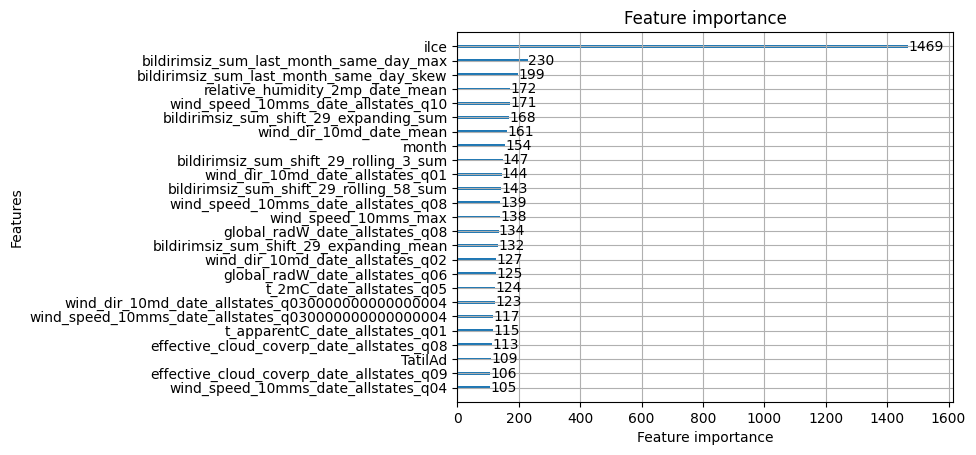

**************************************************
Training data shape: (51465, 97), Validation data shape: (1457, 97)
[100]	training's l1: 2.48899	valid_1's l1: 2.96329
[200]	training's l1: 2.40759	valid_1's l1: 2.93972
[300]	training's l1: 2.33672	valid_1's l1: 2.88605
[400]	training's l1: 2.28089	valid_1's l1: 2.8809
[500]	training's l1: 2.23857	valid_1's l1: 2.84345
Score FOLD-7:2.836650652024708


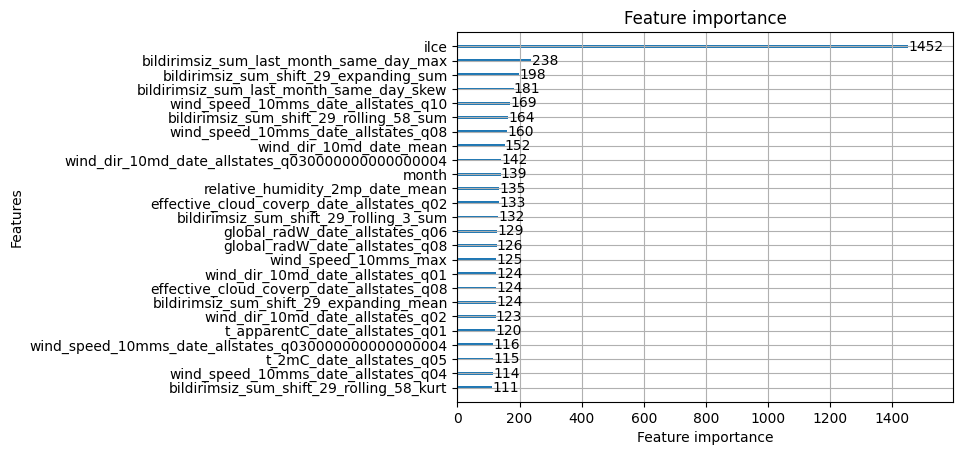

**************************************************
Mean MAE: 2.77127 Std MAE: 0.58115


In [41]:
score_list = []
fold = 1
unseen_preds = []
importance = []
val_results = []
train_results = []
models = []

for train_index, test_index in cv_splits:
    
    X_train,X_val = X.iloc[train_index][selfeats], X.iloc[test_index][selfeats]
    y_train,y_val = y.iloc[train_index],y.iloc[test_index]
    sub_df_subset = sub_df[selfeats].copy()
    
    X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    X_val = X_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    sub_df_subset = sub_df_subset.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")
    
    params = {'learning_rate': 0.15285349538804496,
              'num_leaves': 21,
              'max_depth': 10,
              'bagging_fraction': 0.6096696033827727,
              'bagging_freq': 3,
              'lambda_l1': 3.548472373329298,
              'feature_fraction': 0.6462541168266625,
              'max_bin': 59,
              'tweedie_variance_power': 1.860748981330339,
              'verbose': -1,
              'n_estimators': 500,
              'objective': 'mae',
              'boosting_type': 'dart',
              'force_col_wise': True,
              'deterministic': True
             }
    
    # Create lgb datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    # Train the model
    model = lgb.train(params,
                      train_data,
                      valid_sets=[train_data,val_data],
                      callbacks=[
            lgb.log_evaluation(100)
        ])    
    
    models.append(model)
    forecast_pred = np.round(model.predict(sub_df_subset),0)

    unseen_preds.append(forecast_pred)
    
    val_result = np.round(model.predict(X_val),0)
    val_results.append(val_result)
    
    train_result = model.predict(X_train)
    train_results.append(train_result)
        
    score = mean_absolute_error(y_val,val_result)
    score_t = mean_absolute_error(y_train,train_result)
    
    print(f"Score FOLD-{fold}:{score}")
    score_list.append(score)
    
    lgb.plot_importance(model,max_num_features=25)
    plt.show()
    
    fold += 1
    
    print('*'*50)
    
print("Mean MAE:", round(np.mean(score_list),5),"Std MAE:",round(np.std(score_list),5))

## 6. Bütün Veriyle Eğitim + Tahminleme

In [42]:
np.random.seed(1)
seeds = np.random.randint(low=1,high=1000, size=25)
seeds

array([ 38, 236, 909,  73, 768, 906, 716, 646, 848, 961, 145, 130, 973,
       584, 750, 509, 391, 282, 179, 277, 255, 358, 915, 469, 908])

In [43]:
unseen_preds = []
models = []

for idx,seed in tqdm(enumerate(seeds),total=len(seeds)):
    
    X_train = X[selfeats].copy()
    sub_df_subset = sub_df[selfeats].copy() 
    
    X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    sub_df_subset = sub_df_subset.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    
    params = {'learning_rate': 0.15285349538804496,
              'num_leaves': 21,
              'max_depth': 10,
              'bagging_fraction': 0.6096696033827727,
              'bagging_freq': 3,
              'lambda_l1': 3.548472373329298,
              'feature_fraction': 0.6462541168266625,
              'max_bin': 59,
              'tweedie_variance_power': 1.860748981330339,
              'verbose': -1,
              'n_estimators': 500,
              'objective': 'mae',
              'boosting_type': 'dart',
              'force_col_wise': True,
              'deterministic': True
             }
    
    #Create lgb datasets
    train_data = lgb.Dataset(X_train, label=y)
    sub_data = lgb.Dataset(sub_df_subset, reference=train_data)
    
    # Train the model
    params["random_state"] = seed
    model = lgb.train(params,
                      train_data,
                      valid_sets=[train_data])
    model.save_model(f'model_{idx}.mdl')
    
    models.append(model)
    forecast_pred = model.predict(sub_df_subset)
    unseen_preds.append(forecast_pred)

  0%|          | 0/25 [00:00<?, ?it/s]

In [44]:
test_df = all_df[all_df.data=='test'][['date','il','ilce']].copy()
test_df['bildirimsiz_sum'] = np.clip(np.round(np.mean([i for i in unseen_preds],axis=0)), a_min=0, a_max=999)
test_df['unique_id'] = test_df['date'].astype(str) + "-" + test_df['il'].astype(str) + "-" + test_df['ilce'].astype(str)
test_df = test_df[['unique_id','bildirimsiz_sum']]

In [45]:
ss = ss[['unique_id']].merge(test_df,how='left',on='unique_id')

In [46]:
ss.to_csv('submission.csv',index=False)